In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json("./skaters.ndjson", lines=True)

In [3]:
print(f"{data.shape[0]} skaters and {data.shape[1]} informations for each of them : {data.columns.values}.")
data.head(1)

2971 skaters and 20 informations for each of them : ['skaters_id' 'discipline_id' 'api_id' 'first_name' 'last_name'
 'full_name' 'gender' 'nationality_code' 'organization_code' 'image'
 'thumbnail_image' 'slug' 'status' 'created_at' 'updated_at' 'discipline'
 'discipline_title' 'is_favourite' 'results' 'details'].


,skaters_id,discipline_id,api_id,first_name,last_name,full_name,gender,nationality_code,organization_code,image,thumbnail_image,slug,status,created_at,updated_at,discipline,discipline_title,is_favourite,results,details
0,18,3,5de9e912-6021-4d19-b4e9-3b817e5dcef0,Avalon,Aardoom,Avalon Aardoom,F,NED,NED,https://isu-d8g8b4b7ece7aphs.a03.azurefd.net/i...,https://isu-d8g8b4b7ece7aphs.a03.azurefd.net/i...,avalon-aardoom,Active,2024-09-18 15:48:09+00:00,2025-06-18 21:05:07+00:00,"{'title': 'SHORT TRACK', 'image': 'https://isu...",SHORT TRACK,No,"[{'skaters_competition_results_id': 8210421, '...","{'date_of_birth': '16 Oct 1997', 'height': '17..."


In [4]:
# keep only useful data -> api_id useful to uniquely identify a skater

USEFUL_COLUMNS = ['api_id', 'first_name', 'last_name', 'gender', 'nationality_code', 'slug', 'results', 'details']
data = data[USEFUL_COLUMNS]

## Exploration des données venant de *details*

In [5]:
# create new dataframe with one column for each information given in details columns

skaters_bio = data.copy().drop('results', axis=1)

# retrieve all key in details column
details_keys = set()
for details in skaters_bio['details']:
    details_keys.update(details.keys())
sorted_details_keys = sorted(details_keys)

# create new column for each key in details column
for details_key in sorted_details_keys:
    skaters_bio[details_key] = data['details'].apply(
        lambda x: (
            pd.NA if details_key not in x
            else pd.NA if x[details_key] == "N/A"
            else x[details_key]
        )
    )
skaters_bio = skaters_bio.drop('details', axis=1)

In [6]:
# explore columns to have an overview of the skaters data

# api_id
len(skaters_bio['api_id'].unique()) # 2971
print("- api_id identify each skater once (same for 'slug' column)")

# first_name and last_name
len(skaters_bio['first_name'].unique()) # 2065
len(skaters_bio['last_name'].unique()) # 2364
print("- About 30% of skaters have the same firstname and about 20% of skaters have the same lastname (lastname are less commun than firstname)")

# details
missing_data_in_details_col = (skaters_bio[sorted_details_keys].isna().mean() * 100).to_frame('% missing').sort_values('% missing')
print(f"- A lot of details are missing for each skater (only {len(skaters_bio) - skaters_bio[missing_data_in_details_col['% missing'].idxmax()].isna().sum()} / {len(skaters_bio)} data are availables in the most missing column) :")
missing_data_in_details_col

- api_id identify each skater once (same for 'slug' column)
- About 30% of skaters have the same firstname and about 20% of skaters have the same lastname (lastname are less commun than firstname)
- A lot of details are missing for each skater (only 44 / 2971 data are availables in the most missing column) :


,% missing
date_of_birth,14.978122
start_skating___club,75.934029
languages,77.078425
profession,78.626725
hometown,79.232582
reason_for_choosing_this_sport,81.958936
place_of_birth,81.992595
height,84.315045
hero__idol,84.954561
most_influential_person_in_career,85.358465


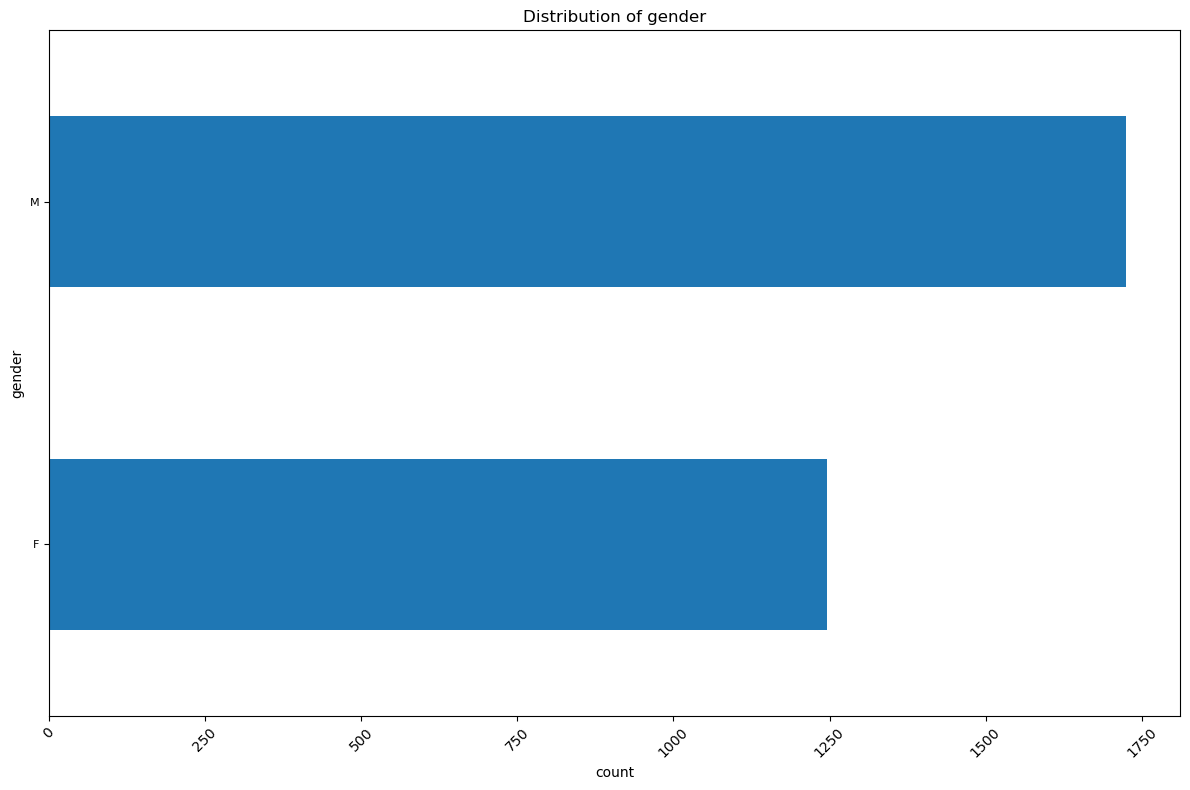

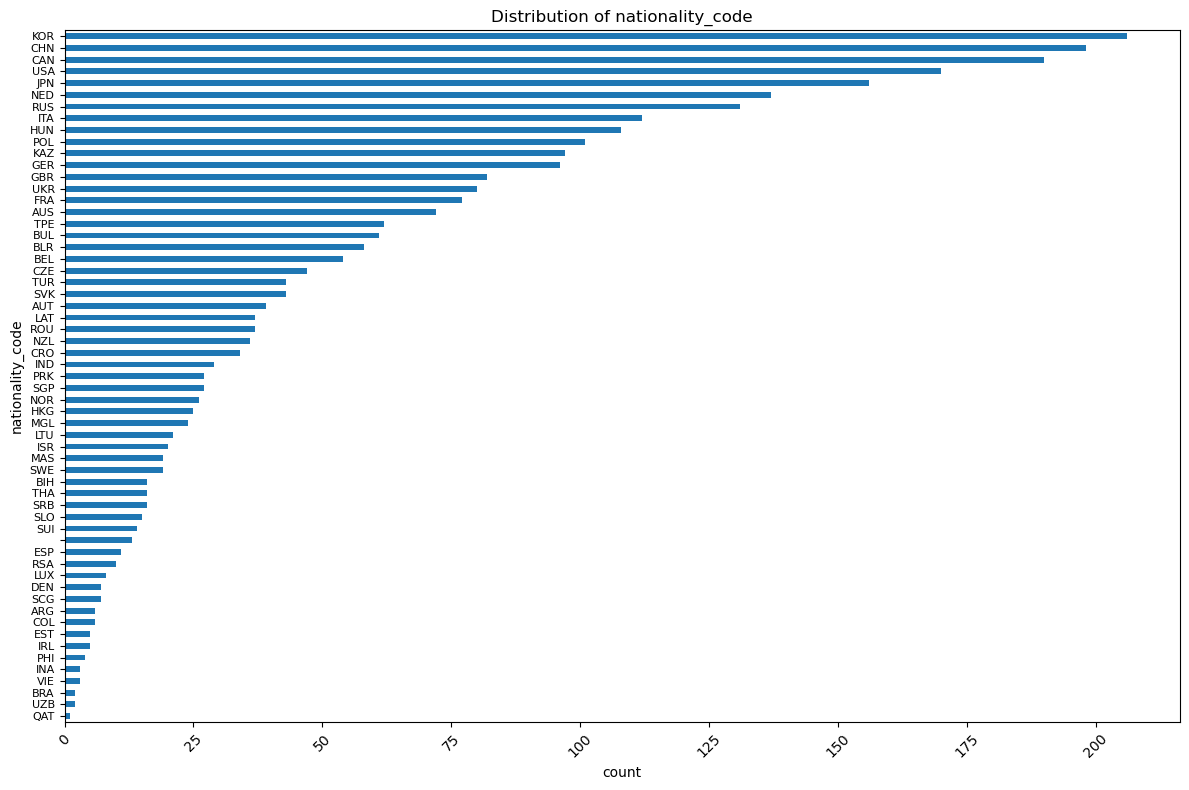

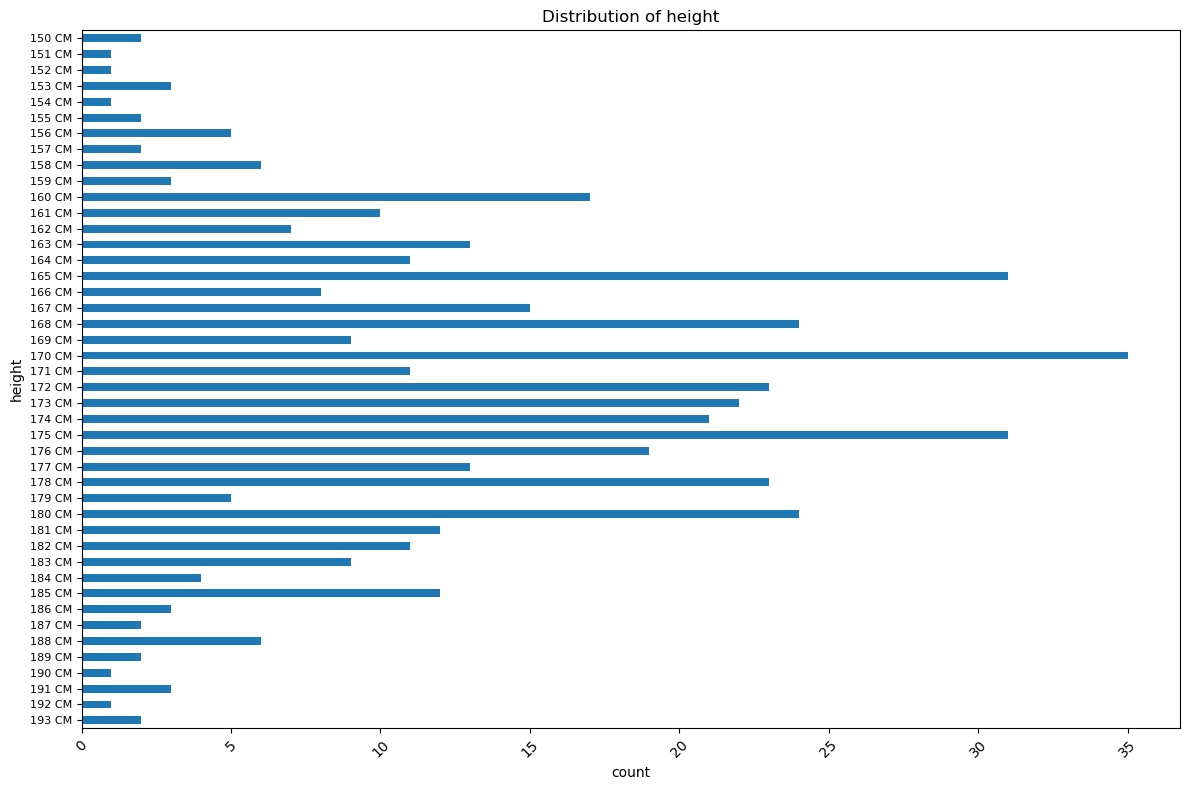

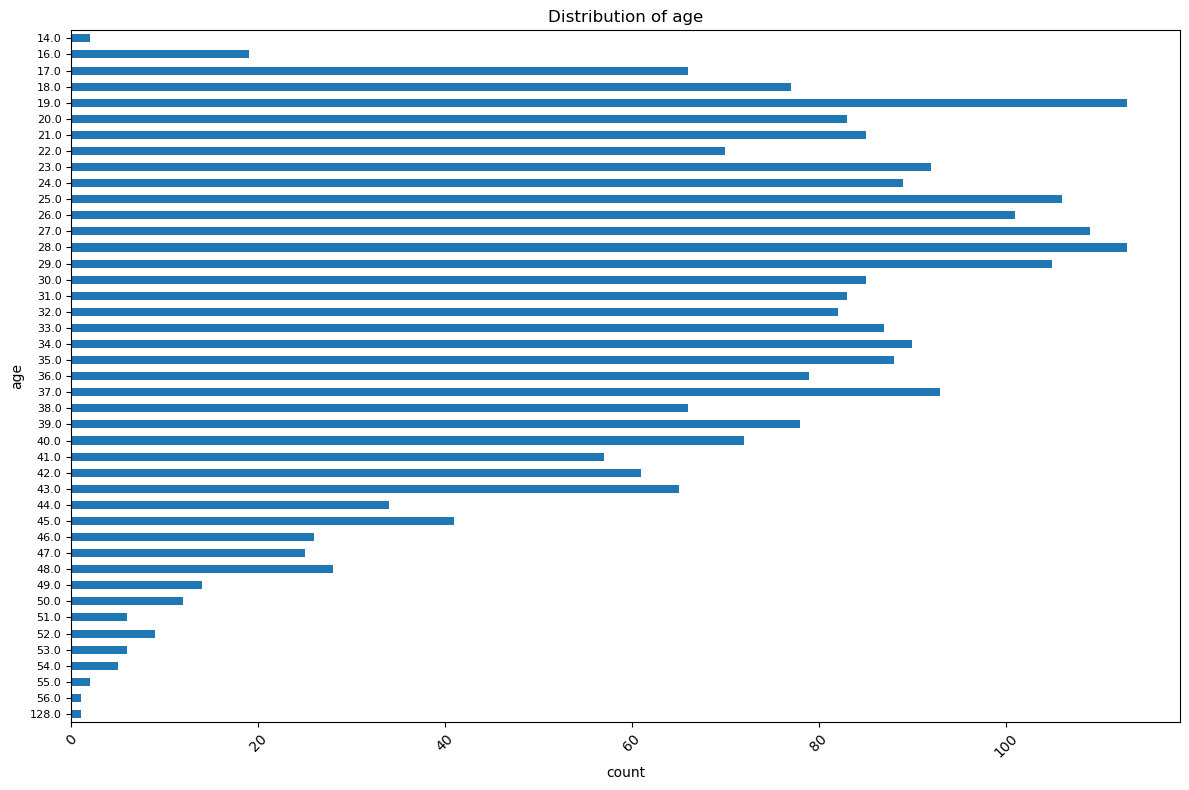

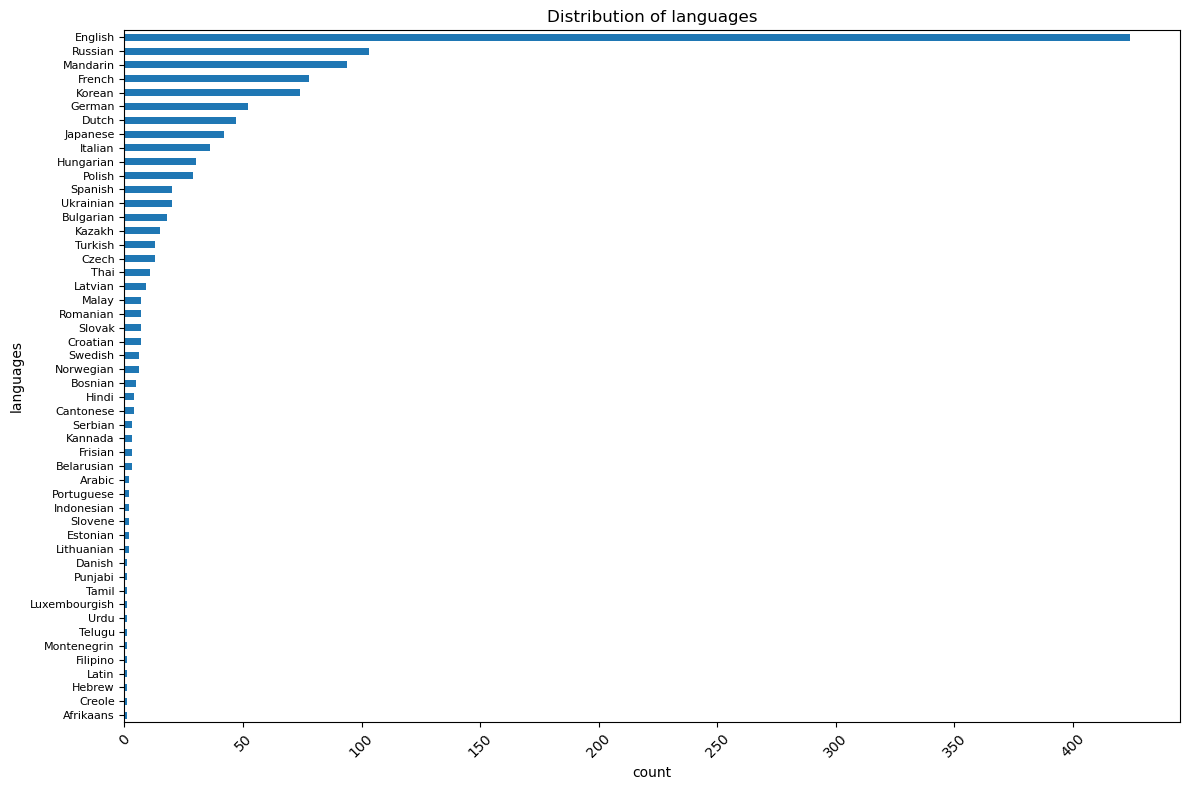

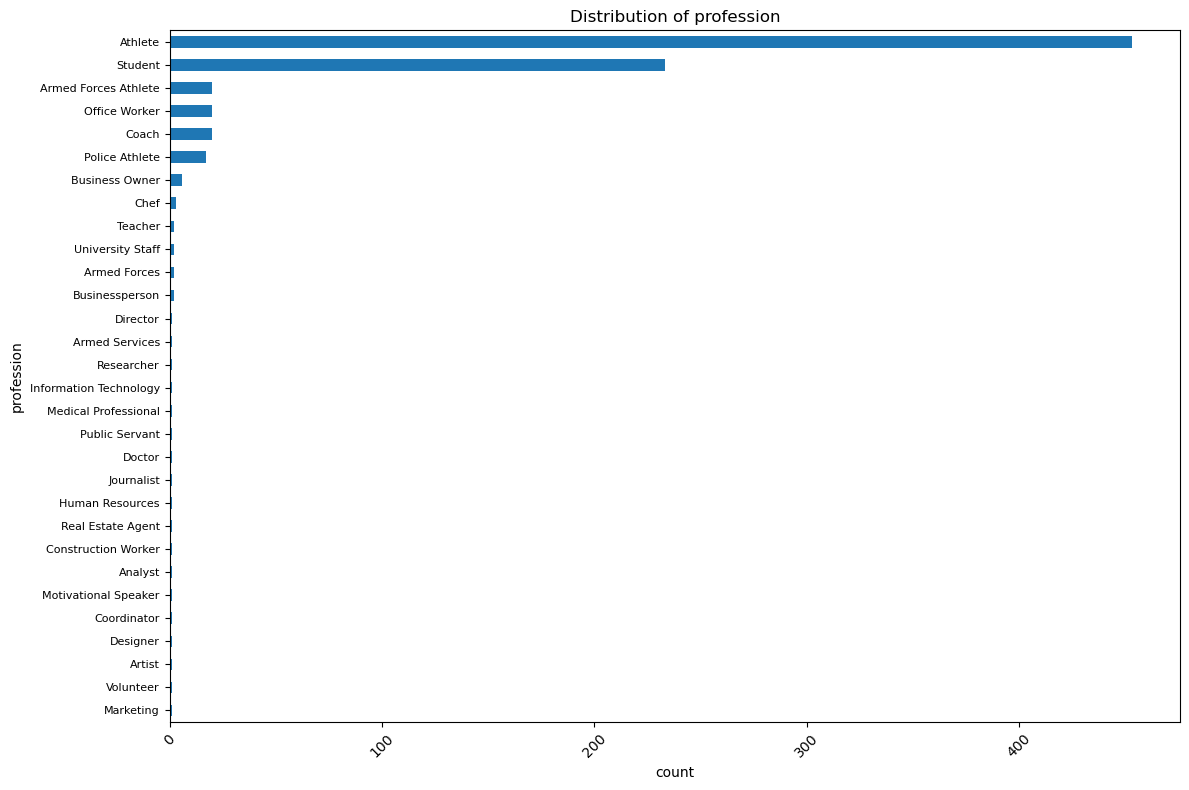

In [7]:
# bar chart with data from: ['gender', 'nationality_code', 'date_of_birth', 'height', 'languages', 'profession']

def plot_barchart(colname, values, sort_by_count=True):
    plt.figure(figsize=(12, 8))

    if sort_by_count:
        values.value_counts().sort_values().plot(kind='barh')
    else:
        values.value_counts().sort_index(ascending=False).plot(kind='barh')

    plt.title(f'Distribution of {colname}')
    plt.xlabel('count')
    plt.ylabel(colname)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0, fontsize=8)
    plt.subplots_adjust(left=0.3)
    plt.tight_layout()
    plt.show()

def ungroup_values(data):
    flat_data = []
    for content in data:
        if pd.isna(content):
            continue
        elif ',' in content:
            elements = [e.strip() for e in content.split(',')]
            for element in elements:
                flat_data.append(element)
        else:
            flat_data.append(content)
    return flat_data

# gender, nationality_code and height can be used with no transformation
plot_barchart('gender', skaters_bio['gender'])
plot_barchart('nationality_code', skaters_bio['nationality_code'])
plot_barchart('height', skaters_bio['height'], False) # TODO : afficher selon le genre

# display age instead of date of birth
dates_of_birth = pd.to_datetime(skaters_bio['date_of_birth'], format="%d %b %Y")
current_year = pd.Timestamp.now().year
ages = current_year - dates_of_birth.dt.year
plot_barchart('age', ages, False)

# separate each language and profession
all_languages = pd.Series(ungroup_values(skaters_bio['languages']))
all_professions = pd.Series(ungroup_values(skaters_bio['profession']))
plot_barchart('languages', all_languages)
plot_barchart('profession', all_professions)

In [8]:
# TODO : traiter ces colonnes autrement -> achievements, ambitions, awards_and_honours, famliy, hero_idol, hobbies, injuries, milestones, most_influencial_person_in_career, other_informations, other_sports, reason_for_choosing_this_sport, sporting_philosophy, start-skating__club, supersititons__rituals__neliefs, training_regime

## Exploration des données venant de *results*

In [9]:
# TODO : focus on data['results']

## Résumé des explorations

Pour information, les données utilisées correspondent à l'ensemble des patineurs recensés sur le site de l'ISU qui font du short track speed skating en date de octobre 2025.

On peut observer :
- plus d'hommes que de femmes (1/4 de plus environ)
- Corée, Chine, Canada, Etas-Unis, Japon et Pay-Bas sont les nationalités les plus présentes
- distribution de la taille suit une loi normale
- athlètes âgés entre 20 et 30 ans sont en majorité
- beaucoup d'athlètes parlent anglais
- une grande partie des athlètes font ce sport comme profession et presque la moité des athlètes sont également des étudiants

Les données présentes dans les colonnes *hometown*, *other_name* et *place_of_birth* n'ont pas été analysées, car elles ne semblent pas pertinentes au vu du contexte.

## Axes d'analyses

- Les nationalités les plus représentées ont-elles plus de contenu disponible que les autres sur le site de l'ISU ?
- Y a-t-il plusieurs athlètes qui partagent le même héro / la même idole ?
- La taille a-t-elle son importance dans ce sport ?
- Quels sont les impacts des blessures sur les résultats d'un athlète ?